In [164]:
## find L, M, S functions by age/sex/region
# We calculated the centiles (0.4, 1, 2.5, 5, 10, 25, 50, 75, 90, 95, 97.5, 99, 99.6) for each regional 
# # cortical thickness measure by sex and hemisphere as normalized growth centiles using parametric 
# # Lambda (λ), Mu (μ), Sigma (σ) (LMS) method (Cole and Green, 1992) in the Generalized Additive Models
# #  for Location, Scale and Shape (GAMLSS) package in R (http://cran.r-project.org/web/packages/gamlss/index.html) 
# #(Rigby & Stasinopoulos, 2005; Stasinopoulos & Rigby, 2007). LMS is considered a powerful method for estimating 
# #centile curves based on the distribution of a response variable at each covariate value (in this case age).
# # GAMLSS uses a penalized maximum likelihood function to estimate parameters of smoothness (effective degrees of 
# #freedom) which are then used to estimate the λ, μ, and σ parameters. The goodness of fit for these parameters in 
# #the GAMLSS algorithm is established by minimizing the Generalized Akaike Information Criterion (GAIC) index.

# if we can estimate L,M,S then we can estimate centiles and therefore z-scores for each subject and region.

import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

In [368]:
# load the centile information
# male
male_centiles = pd.read_csv('/Users/emilyolafson/GIT/ENIGMA/cortical_atrophy/centiles_CT_males.csv', header=0)
male_centiles.rename(columns={'Unnamed: 0':'Region'},inplace = True)

# female
female_centiles = pd.read_csv('/Users/emilyolafson/GIT/ENIGMA/cortical_atrophy/centiles_CT_females.csv', header=0)
female_centiles.rename(columns={'Unnamed: 0':'Region'},inplace = True)

# load cortical thickness data to get headers (regions)
rh_thickness =  pd.read_table('/Users/emilyolafson/GIT/ENIGMA/data/FREESURFER/aseg_aparc/aparc_rh_stats_thickness.txt', header=0)
lh_thickness =  pd.read_table('/Users/emilyolafson/GIT/ENIGMA/data/FREESURFER/aseg_aparc/aparc_lh_stats_thickness.txt', header=0)

# change col names so they match centile naming
newRcols=[]
newLcols=[]
for x in rh_thickness.columns: newRcols.append(x.replace('_thickness', '').replace('rh_', 'R_'))
for x in lh_thickness.columns: newLcols.append(x.replace('_thickness', '').replace('lh_', 'L_'))

rh_thickness.columns = newRcols
lh_thickness.columns = newLcols

print(len(rh_thickness.columns))

36


In [343]:
list_centiles = [0.004, 0.01, 0.025, .05, .10, .25, .50, .75, .90, .95, .975, 0.99, .996]

for i in range(0,2):
    print(i)
    region = rh_thickness.columns[1]
    print(region)

    #male
    idx=np.empty((13,1))

    for i in range(0,13): idx[i] =np.where(male_centiles['Region']==region)[0][0]+i

    centiles = male_centiles.iloc[idx[1]]

    centiles=centiles.values[0][2:15]

    min_ssd = np.empty((len(idx),1))

    Z = st.norm.ppf(list_centiles) #alpha to Z via norm

    Calphas_true = centiles
    M=[]
    L=[]
    S=[]

    nM =100
    nL =100
    nS =100
    Ms = np.logspace(0,10,nM,base=2)
    Ls = np.linspace(1,10,nL)
    Ss = np.linspace(-0.1,0.1,nS)

    Mc=np.arange(0,nM)
    Sc=np.arange(0,nS)
    Lc=np.arange(0,nL)

    ssd = np.empty((nM,nL,nS))
    lowestssd=1
    for m in Mc: 
        M = Ms[m]
        for l in Lc: 
            L=Ls[l]
            for s in Sc:
                S = Ss[s]
                Calpha_pred = pow(M*(1+S*Z*L),1/L)
                
                ssd[m,l,s]=np.sum((Calpha_pred-Calphas_true)**2)
                if ssd[m,l,s] < lowestssd:
                    lowestssd = ssd[m,l,s]
                    Cpreds = Calpha_pred
                    calphs=Calphas_true
                    bestm = M
                    bestl = L
                    bests = S

    min_ssd[i]= np.nanmin(ssd)



0
R_bankssts


<ipython-input-343-b62f502ea0fa>:45: RuntimeWarning: invalid value encountered in power
  Calpha_pred = pow(M*(1+S*Z*L),1/L)


1
R_bankssts


In [344]:
min_ssd

array([[-0.00000000e+000, -0.00000000e+000],
       [ 6.42285340e-323,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [-0.00000000e+000, -0.00000000e+000],
       [ 2.47032823e-323,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000],
       [-0.00000000e+000, -2.00000015e+000],
       [ 1.39445518e-003,  1.39445518e-003]])

In [320]:
Cpreds

array([2.47780245, 2.55437377, 2.63831945, 2.70880663, 2.78825576,
       2.91703508, 3.05487026, 3.18779427, 3.30366483, 3.37144344,
       3.42934087, 3.49566951, 3.55378379])

In [394]:
list_centiles = [0.004, 0.01, 0.025, .05, .10, .25, .50, .75, .90, .95, .975, 0.99, .996]
ages =[20,30,40,50,6,70,80,90]
f_agerange= [5,10,15,20,30,40,50,60,70,80,90]
m_agerange=[3,5,10,15,20,30,40,50,60,70,80,90]
age_start=m_agerange.index(ages[0])
print(age_start+len(ages))
min_ssd = np.empty((len(rh_thickness.columns),len(ages)))
best_params = np.empty((len(rh_thickness.columns),len(ages),3))

for regionid in range(1,len(rh_thickness.columns)+1):
    
    region = rh_thickness.columns[regionid]
    print(region)

    #male
    idx=np.empty((len(list_centiles),1))

    for i in range(0,len(list_centiles)): idx[i] =np.where(male_centiles['Region']==region)[0][0]+i

    for age in range(age_start,age_start+len(ages)):
        centiles = male_centiles.iloc[idx[age]] #
        centiles=centiles.values[0][2:15] # get rid of first 2 cols
        
        Z = st.norm.ppf(list_centiles) #alpha to Z via norm

        Calphas_true = centiles
        M=[]
        L=[]
        S=[]

        nM =100
        nL =100
        nS =100
        Ms = np.logspace(0,10,nM,base=2)
        Ls = np.linspace(1,10,nL)
        Ss = np.linspace(-0.1,0.1,nS)

        Mc=np.arange(0,nM)
        Sc=np.arange(0,nS)
        Lc=np.arange(0,nL)

        ssd = np.empty((nM,nL,nS))
        lowestssd=1
        for m in Mc: 
            M = Ms[m]
            for l in Lc: 
                L=Ls[l]
                for s in Sc:
                    S = Ss[s]
                    Calpha_pred = pow(M*(1+S*Z*L),1/L)
                    
                    ssd[m,l,s]=np.sum((Calpha_pred-Calphas_true)**2)
                    if ssd[m,l,s] < lowestssd:
                        lowestssd = ssd[m,l,s]
                        Cpreds = Calpha_pred
                        calphs=Calphas_true
                        bestmls = [M,L,S]

        min_ssd[regionid,age]=np.nanmin(ssd)
        best_params[regionid,age,:,:,:]=bestmls
    



12
R_bankssts


<ipython-input-394-b76c6ac75b0a>:50: RuntimeWarning: invalid value encountered in power
  Calpha_pred = pow(M*(1+S*Z*L),1/L)


In [ ]:
np.where(male_centiles['Region']==region)[0][0]+i

In [370]:
print(len(list_centiles))

13


In [390]:
a



4

In [358]:
min_ssd[1]

0.0013944551750008187

0.9995944146832828

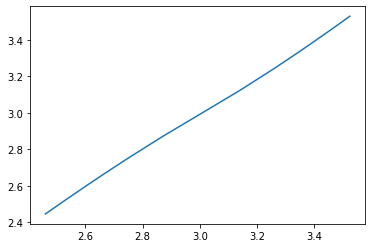

In [332]:
plt.plot(Cpreds,Calphas_true)
from sklearn.metrics import explained_variance_score
explained_variance_score(Cpreds,Calphas_true)